In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd


# Définition du réseau
class SimpleNN(nn.Module):
    def __init__(self, n=2, h=20):
        super(SimpleNN, self).__init__()
        
        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
        #             nn.BatchNorm1d(h),
            #nn.ReLU(),
            nn.Tanh(), 
            nn.Linear(h, h), 
        #             nn.BatchNorm1d(h),
            #nn.ReLU(),
            nn.Tanh(),
        #             nn.Linear(h, h), 
        #             nn.BatchNorm1d(h),
        #             nn.ReLU(),
        )
        
        self.clf = nn.Linear(h, 1, bias=False)
        
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)




In [149]:
# Génération de données
from sklearn.datasets import make_moons, make_blobs
import numpy as np

def generate_data(n_samples=500, kind='moons'):
    if kind == 'blobs':
        X, y = make_blobs(n_samples=n_samples, centers=[(-2, -2), (2,  2)], cluster_std=[1.0, 1.0], random_state=42)
    else:
        X, y = make_moons(n_samples=n_samples, noise=0.1, shuffle=True, random_state=42)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

X_train, y_train = generate_data(n_samples=90, kind='moons')
X_val, y_val = generate_data(n_samples=200, kind='moons')

y_train = y_train.float()
y_val = y_val.float()

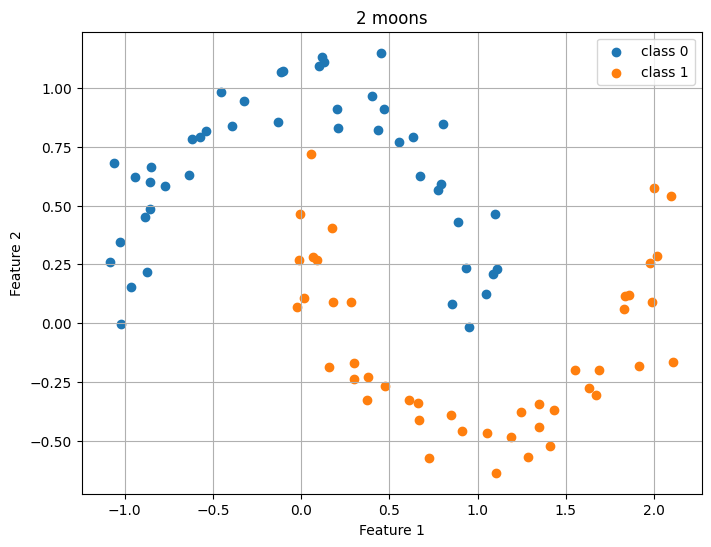

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label= 'class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label= 'class 1')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2 moons")
plt.legend()
plt.grid(True)
plt.show()

In [151]:
# Initialisation
model = SimpleNN()
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=sigma_0_squarred) # weight decay equivaut à une régularisation L2
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [152]:
# Entraînement
from sklearn.metrics import accuracy_score
n_epochs = 5000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs.view(-1), y_train)
    loss.backward()
    optimizer.step()
print(f'loss training : {loss.item()}')

# Evaluation
with torch.no_grad():
    logits = model(X_test)
    preds = (logits.squeeze() > 0).long()
    accuracy = accuracy_score(y_test, preds)

print(f"Précision du modèle classique : {accuracy:.2f}")

loss training : 0.20360571146011353
Précision du modèle classique : 0.93


In [153]:
def compute_hessian(loss, params, exact=True, tau=1e-4):
    grads = autograd.grad(loss, params, create_graph=True, retain_graph=True)
    grads_flat = torch.cat([grad_params.view(-1) for grad_params in grads])
    hessian = torch.zeros(grads_flat.shape[0], grads_flat.shape[0])                    
    for i in range(grads_flat.shape[0]):
        hessian_row = autograd.grad(grads_flat[i], params, retain_graph=True)
        hessian_row = torch.cat([hessian_row_params.view(-1) for hessian_row_params in hessian_row])
        hessian[i, :] = hessian_row
    if not exact:
        hessian = hessian + tau*torch.eye(hessian.shape[0])
    return hessian 

In [154]:
def compute_gn_hessian(likelyhood, params, exact=False, tau=1e-4):
    grads = autograd.grad(likelyhood, params, create_graph=True, retain_graph=True)
    grads_flat = torch.cat([grad_params.view(-1) for grad_params in grads])
    diag_F = grads_flat ** 2
    if not exact:
        hessian = tau + diag_F
    return hessian * torch.eye(grads_flat.shape[0])

In [50]:
from tqdm import tqdm
def optimize_var0(X_val, y_val, model, X_train, y_train, method='FLA', lamda=1.0):
    logvar0s = torch.linspace(-10, 20, 300)
    nlls = []
        
    X_out = torch.rand(50, 2) * 6 - 3 
    y_out = torch.full((50,), 0.5)
    diag = True if method == 'FLA' else False
    
    pbar = tqdm(logvar0s, position=0, leave=True)

    for logvar0 in pbar:
        var0 = torch.exp(logvar0)
        
        out_in = closed_form_confidence(model, nn.BCEWithLogitsLoss(reduction='sum'), X_train, y_train, X_val, var0=var0, method=method, apply_sigm=False, diag=diag)
        loss_in = nn.BCEWithLogitsLoss()(out_in, y_val).detach().item()
        
        out_out = closed_form_confidence(model, nn.BCEWithLogitsLoss(reduction='sum'), X_train, y_train, X_out, var0=var0, method=method, apply_sigm=False, diag=diag)
        loss_out = nn.BCEWithLogitsLoss()(out_out, y_out).detach().item()
        
        loss = loss_in + lamda*loss_out
        
        nlls.append(loss)

        pbar.set_description(f'var0: {var0:.3f}, Loss: {loss:.3f}, loss_in: {loss_in:.3f}, loss_out: {loss_out:.3f}')
            
    best_logvar0 = logvar0s[np.nanargmin(np.array(nlls))]

    return torch.exp(best_logvar0)
optimize_var0(X_test, y_test, model, X_train, y_train, method='FLA')

var0: 0.042, Loss: nan, loss_in: nan, loss_out: nan:  23%|██▎       | 69/300 [00:12<00:42,  5.44it/s]      


KeyboardInterrupt: 

In [371]:
optimize_var0(X_test, y_test, model, X_train, y_train, method='FLA')

var0: 0.008, Loss: 1.338, loss_in: 0.640, loss_out: 0.699:  18%|█▊        | 53/300 [01:57<09:09,  2.23s/it]


KeyboardInterrupt: 

In [313]:
optimize_var0(X_test, y_test, model, X_train, y_train, method='LLLA')

var0: 485165184.000, Loss: 0.968: 100%|██████████| 100/100 [00:02<00:00, 39.89it/s]


tensor(40378.7930)

In [155]:
def closed_form_confidence(model, criterion, X_train, y_train, X, method='LLLA', var0=1e5, apply_sigm=True, diag=False):
    y_pred = model(X_train)
    W_list = list(model.parameters()) if method == 'FLA' else [list(model.parameters())[-1]]
    likelihood = criterion(y_pred.view(-1), y_train)
    reg = 0
    for W in W_list: 
        reg += 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()
    loss = likelihood + reg
    
    if diag:
        hessian = compute_hessian(loss, W_list, exact=True)
        hessian = hessian.diag() * torch.eye(hessian.shape[0])
    else:
        hessian = compute_hessian(loss, W_list, exact=True)
    sigma = torch.inverse(hessian)
    confidences = torch.zeros(X.shape[0])
    if method == 'FLA':
        d = []
        f_mu = model(X)
        for i in range(X.shape[0]):
            d_ = autograd.grad(f_mu[i], W_list, retain_graph=True)
            d_flat = torch.cat([d_layer.view(-1) for d_layer in d_])
            d.append(d_flat)
        f_mu = f_mu.view(-1)
        d = torch.stack(d)
        denominator = torch.sqrt(1 + (torch.pi / 8) * torch.diag(d @ sigma @ d.T))
        z = f_mu / denominator
        confidences = torch.sigmoid(z) if apply_sigm  else z
    else: # method == 'LLLA'
        phi = model.feature_extr(X)
        w_map = W_list[0].view(-1) # mu
        numerator =  phi @ w_map
        denominator = torch.sqrt(1 + (torch.pi / 8) * (phi @ sigma @ phi.T).diag())
        z = numerator / denominator
        confidences = torch.sigmoid(z) if apply_sigm  else z
    return confidences
    
# confidences = closed_form_confidence(model, nn.BCEWithLogitsLoss(reduction='sum'), X_train, y_train, X_test, method='FLA', diag=True)
# confidences

In [ ]:
def optimize_temp(model, X_test, y_test):
    logit_val = model(X_test).squeeze().detach()
    
    T = torch.tensor(1).float()
    T.requires_grad = True
    
    optimizer = optim.LBFGS([T], lr=0.1, max_iter=50)
    
    def eval():
        optimizer.zero_grad()
        loss = nn.BCEWithLogitsLoss()(logit_val/T, y_test)
        loss.backward()
        return loss
    
    optimizer.step(eval)
    
    T = T.detach().item()
    print(f'Temp: {T}')
optimize_temp(model, X_test, y_test)

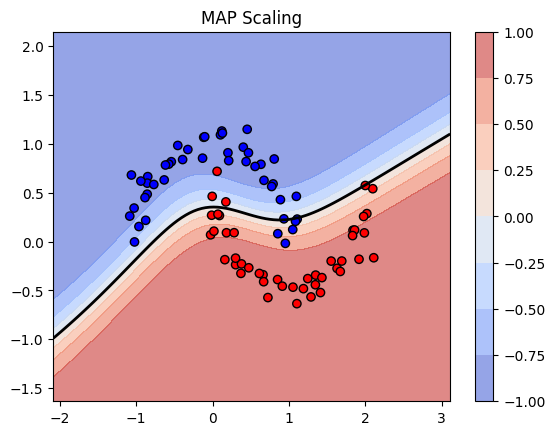

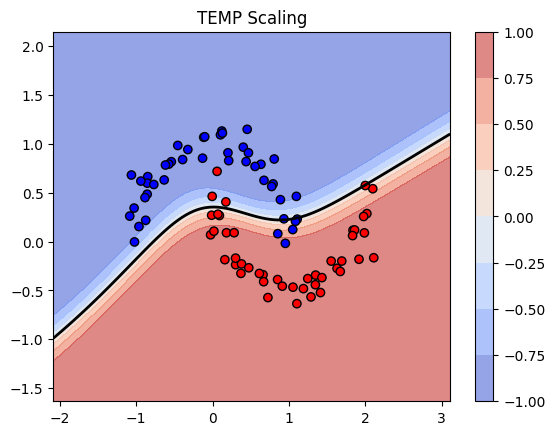

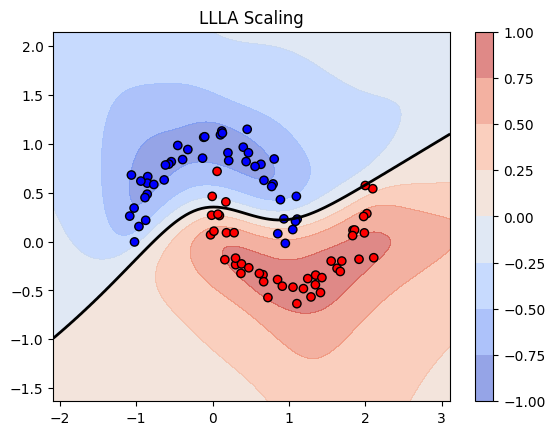

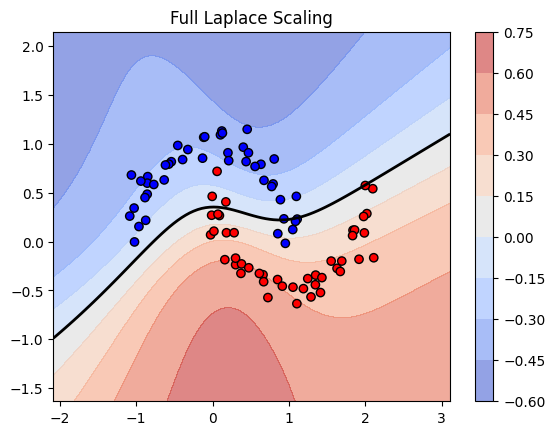

In [156]:
var0 = 949.7386 # 949.7386 FLA, 40378.7930 LLLA

def plot_decision_boundary(X_train, y_train, method='MAP', var0=1e5, diag=False, title='MAP Scaling', criterion=nn.BCEWithLogitsLoss(reduction='sum'), T = 1):
    x_min, x_max = 1*(X_train[:, 0].min() - 1), 1*(X_train[:, 0].max() + 1)
    y_min, y_max = 1*(X_train[:, 1].min() - 1), 1*(X_train[:, 1].max() + 1)
    
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100, dtype=torch.float32),
                        torch.linspace(y_min, y_max, 100, dtype=torch.float32),
                        indexing='ij')  # Ajout de indexing='ij' pour suivre le comportement de NumPy
    
    grid = torch.stack([xx.ravel(), yy.ravel()], dim=1)
    
    
    if method == 'FLA' or method == 'LLLA': # Laplace
        preds = closed_form_confidence(model, criterion, X_train, y_train, grid, method=method, var0=var0, diag=diag).reshape(xx.shape).detach()
    else: # method == 'MAP'
        with torch.no_grad():
            logits = model(grid).squeeze()
            Temp = T if method == 'TEMP' else 1
            preds = torch.sigmoid(logits/Temp).reshape(xx.shape)
            # preds = -preds*np.log(preds+1e-8) - (1-preds)*np.log(1-preds+1e-8)
            # preds = np.maximum(preds, 1-preds)
    
    # Confiance = |2p - 1|
    confidence = 2 * preds - 1
    
    plt.contourf(xx, yy, confidence, alpha=0.6, cmap='coolwarm')
    plt.colorbar()
    
    # Frontière de décision
    plt.contour(xx, yy, preds, levels=[0.5], colors='black', linewidths=2)
    
    # Points
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolors='k')
    
    plt.title(title)
    plt.show()

plot_decision_boundary(X_train, y_train, method='MAP', title='MAP Scaling')
plot_decision_boundary(X_train, y_train, method='TEMP', T=0.5994904041290283, title='TEMP Scaling')
plot_decision_boundary(X_train, y_train, method='LLLA', var0=40378.7930, diag=False, title='LLLA Scaling')
plot_decision_boundary(X_train, y_train, method='FLA', var0=101, diag=True, title='Full Laplace Scaling')


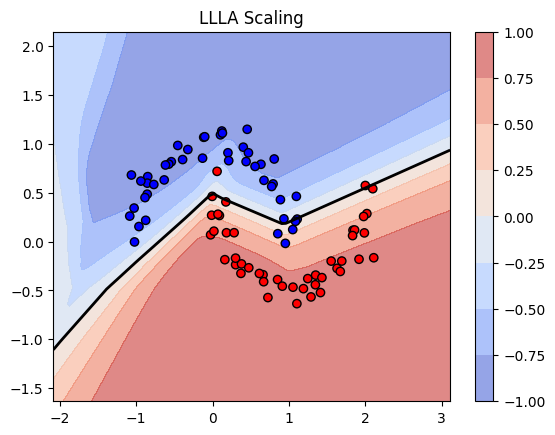

In [149]:
plot_decision_boundary(X_train, y_train, method='LLLA', var0=40378.7930, diag=True, title='LLLA Scaling')

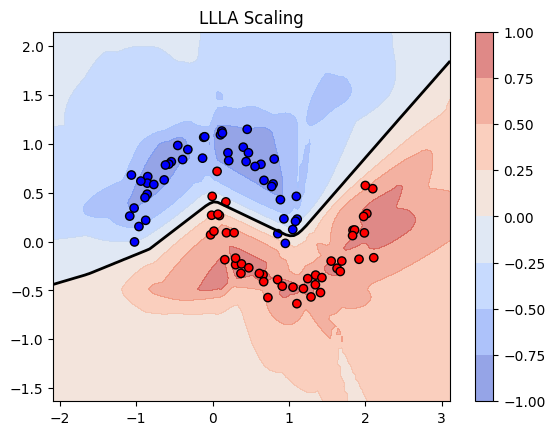

In [134]:
plot_decision_boundary(X_train, y_train, method='LLLA', var0=1e8, diag=False, title='LLLA Scaling')

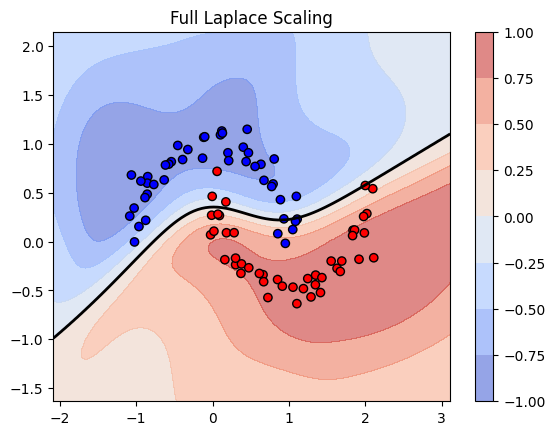

In [165]:
plot_decision_boundary(X_train, y_train, method='FLA', var0=1e5, diag=False, title='Full Laplace Scaling')

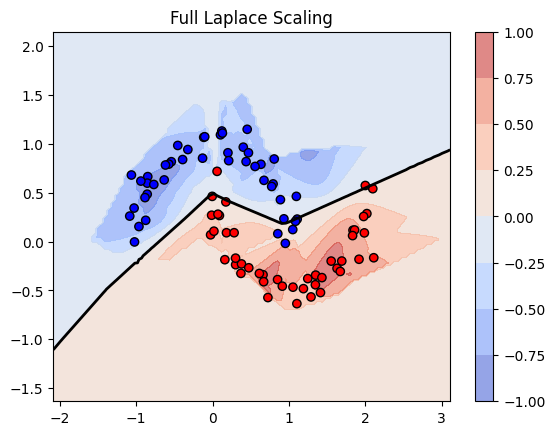

In [148]:
plot_decision_boundary(X_train, y_train, method='FLA', var0=40378.7930, diag=False, title='Full Laplace Scaling')

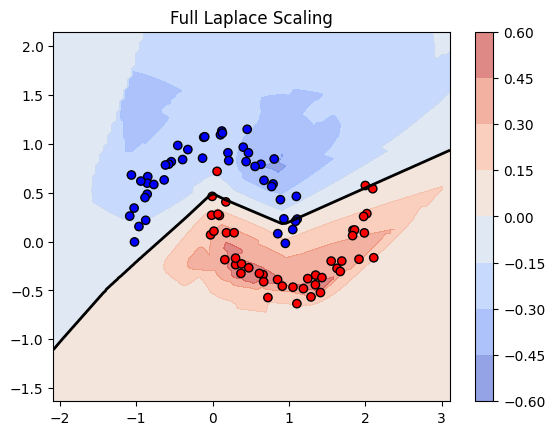

In [147]:
plot_decision_boundary(X_train, y_train, method='FLA', var0=40378.7930, diag=True, title='Full Laplace Scaling')

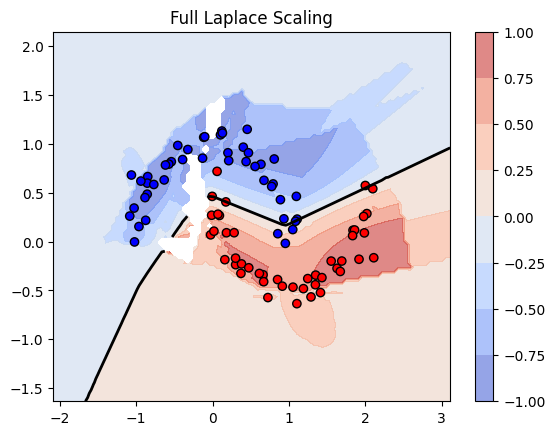

In [19]:
plot_decision_boundary(X_train, y_train, method='FLA', var0=5e2, diag=False, title='Full Laplace Scaling')

In [119]:
X_val, y_val = generate_data(n_samples=200, kind='moons')

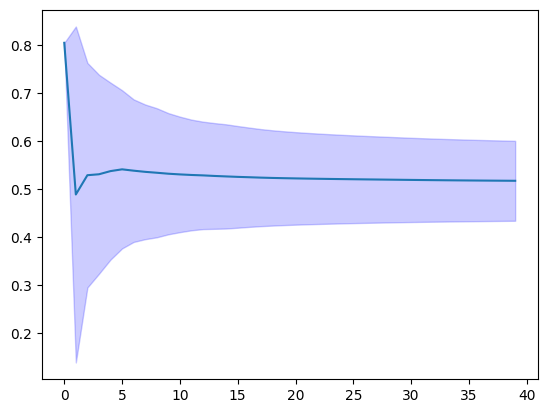

In [122]:
criterion = nn.BCEWithLogitsLoss(reduction='sum')
mean_preds_map = []
std_preds_map = []
for delta in range(40):
    preds_map = closed_form_confidence(model, criterion, X_train, y_train, delta*X_val, method='MAP')
    mean_preds_map.append(preds_map.mean().item())
    std_preds_map.append(preds_map.std().item())  # Écart-type
mean_preds_map = np.array(mean_preds_map)
std_preds_map = np.array(std_preds_map)
plt.plot(mean_preds_map)
plt.fill_between(range(40), mean_preds_map - std_preds_map, mean_preds_map + std_preds_map, color='blue', alpha=0.2, label="±3 std")

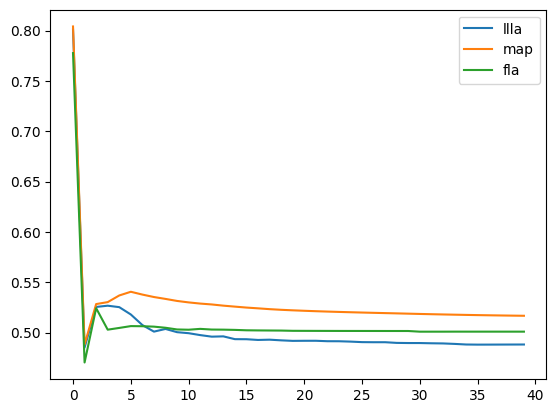

In [136]:
plt.plot(mean_preds_llla, label='llla')

plt.plot(mean_preds_map, label='map')
plt.plot(mean_preds_fla, label='fla')
plt.legend()
plt.show()

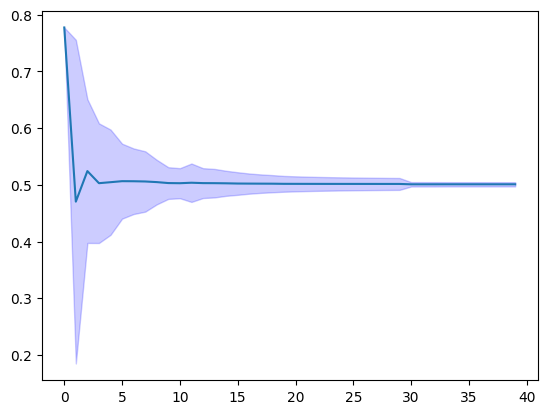

In [126]:
criterion = nn.BCEWithLogitsLoss(reduction='sum')
mean_preds_fla = []
std_preds_fla = []
for delta in range(40):
    preds_fla = closed_form_confidence(model, criterion, X_train, y_train, delta*X_val, method='FLA', var0=40378.7930, apply_sigm=True, diag=False)
    mean_preds_fla.append(preds_fla.mean().item())
    std_preds_fla.append(preds_fla.std().item())  # Écart-type
mean_preds_fla = np.array(mean_preds_fla)
std_preds_fla = np.array(std_preds_fla)
plt.plot(mean_preds_fla)
plt.fill_between(range(40), mean_preds_fla - std_preds_fla, mean_preds_fla + std_preds_fla, color='blue', alpha=0.2, label="±3 std")

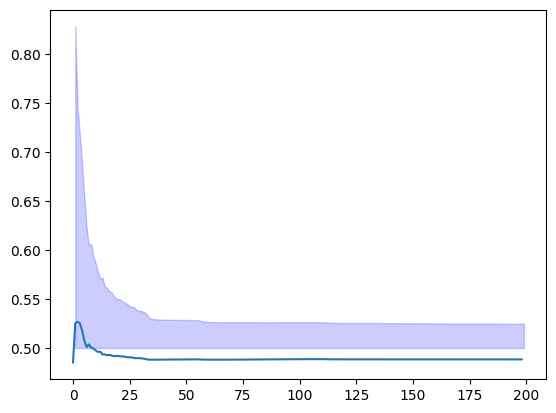

In [142]:
criterion = nn.BCEWithLogitsLoss(reduction='sum')
mean_preds_llla = []
std_preds_llla = []
for delta in range(1, 200):
    preds_llla = closed_form_confidence(model, criterion, X_train, y_train, delta*X_val, method='LLLA', var0=1e8, apply_sigm=True, diag=False)
    mean_preds_llla.append(preds_llla.mean().item())
    std_preds_llla.append(preds_llla.std().item())  # Écart-type
mean_preds_llla = np.array(mean_preds_llla)
std_preds_llla = np.array(std_preds_llla)
plt.plot(mean_preds_llla)
plt.fill_between(range(1, 200), 0.5, mean_preds_llla + std_preds_llla, color='blue', alpha=0.2, label="±3 std")

In [143]:
mean_preds_llla

array([0.48521927, 0.52550423, 0.52672648, 0.52528429, 0.5179947 ,
       0.50748175, 0.50097281, 0.50362623, 0.50041789, 0.49940944,
       0.49752   , 0.49597043, 0.49626324, 0.49348763, 0.49342075,
       0.49269974, 0.49297431, 0.4923079 , 0.49178413, 0.49186721,
       0.49188605, 0.49144828, 0.49141148, 0.49105331, 0.49053806,
       0.4904412 , 0.49044675, 0.48977637, 0.48963261, 0.48962349,
       0.48939255, 0.48923934, 0.48877308, 0.48817769, 0.48805493,
       0.48807606, 0.48811522, 0.48814797, 0.48817673, 0.48820505,
       0.48823169, 0.48825669, 0.4882822 , 0.48830661, 0.48833007,
       0.48835266, 0.48837402, 0.48839447, 0.48841423, 0.48843342,
       0.48845187, 0.48846817, 0.48848397, 0.4884991 , 0.48851395,
       0.48841611, 0.48827499, 0.48818421, 0.48813385, 0.48810542,
       0.48808992, 0.48808244, 0.48808002, 0.4880811 , 0.48808455,
       0.48808983, 0.48809615, 0.48810333, 0.48811108, 0.48811874,
       0.48812631, 0.48813412, 0.48814201, 0.48815009, 0.48815

## Multivariate

In [166]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd


# Définition du réseau
class SimpleNNManyClasses(nn.Module):
    def __init__(self, n=2, h=20, out=4):
        super(SimpleNNManyClasses, self).__init__()
        
        self.feature_extr = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU(),
        #             nn.Linear(h, h), 
        #             nn.BatchNorm1d(h),
        #             nn.ReLU(),
        )
        
        self.clf = nn.Linear(h, out, bias=False)
        
    def forward(self, x):
        x = self.feature_extr(x)
        return self.clf(x)

In [167]:
# Génération de données
from sklearn.datasets import make_moons, make_blobs
import numpy as np

X_train, y_train = make_blobs(n_samples=500, centers=4, cluster_std=1.2, center_box=(-10, 10), random_state=42)
X_val, y_val = make_blobs(n_samples=100, centers=4, cluster_std=1.2, center_box=(-10, 10), random_state=42)
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)

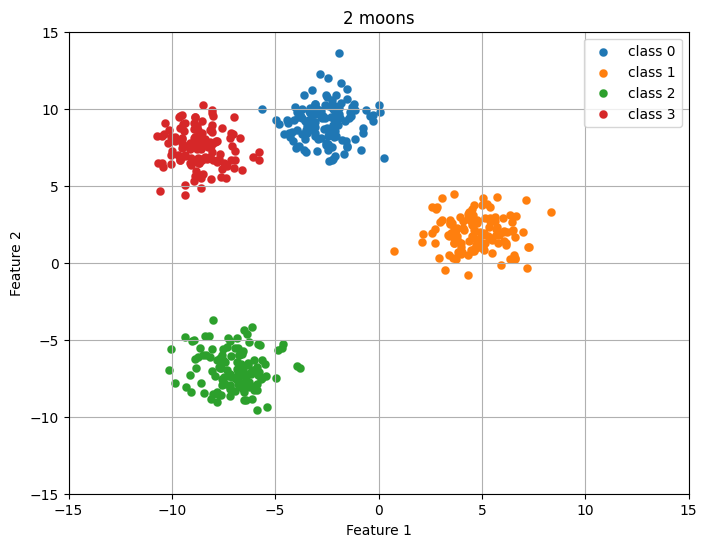

In [168]:
import matplotlib.pyplot as plt
test_range = (-15, 15)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label= 'class 0', linewidths=0.1)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label= 'class 1', linewidths=0.1)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], label= 'class 2', linewidths=0.1)
plt.scatter(X_train[y_train == 3, 0], X_train[y_train == 3, 1], label= 'class 3', linewidths=0.1)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("2 moons")
plt.xlim(test_range)
plt.ylim(test_range)
plt.legend()
plt.grid(True)
plt.show()

In [169]:
# Initialisation
model_manyclasses = SimpleNNManyClasses()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=sigma_0_squarred) # weight decay equivaut à une régularisation L2
optimizer = optim.SGD(model_manyclasses.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [170]:
# Entraînement
from sklearn.metrics import accuracy_score
n_epochs = 5000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model_manyclasses(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
print(f'loss training : {loss.item()}')

# Evaluation
# with torch.no_grad():
#     logits = model_manyclasses(X_val)
#     preds = (logits.squeeze() > 0).long()
#     accuracy = accuracy_score(y_val, preds)

# print(f"Précision du modèle classique : {accuracy:.2f}")

loss training : 0.003754491452127695


In [60]:
model_manyclasses.eval()

SimpleNNManyClasses(
  (feature_extr): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (clf): Linear(in_features=20, out_features=4, bias=False)
)

In [61]:
mc_it = 10
var0 = 1e5
diag = True
method = 'FLA'
X = X_val
criterion = nn.CrossEntropyLoss(reduction='sum')
n_classes = 4

def mc_confidence(model_manyclasses, criterion, X_train, y_train, X, n_classes=4, mc_it=10, method=method, var0=var0, diag=diag, exact=False, tau=None):
    
    def set_model_params(W_list, theta_sample):
        idx = 0
        for p in W_list:
            n_params = p.numel()
            p.data = theta_sample[idx:idx+n_params].reshape(p.shape)
            idx += n_params
    tau = 1/var0 if not tau else tau
    
    model_manyclasses.zero_grad()
    
    y_pred = model_manyclasses(X_train)
    W_list = list(model_manyclasses.parameters()) if method == 'FLA' else [list(model_manyclasses.parameters())[-1]]
    likelihood = criterion(y_pred, y_train)
    reg = 0
    for W in W_list: 
        reg += 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()
    loss = likelihood + reg

    hessian = compute_hessian(loss, W_list, exact=exact, tau=tau)
    if diag:
        hessian = hessian.diag() * torch.eye(hessian.shape[0])
        
    sigma = torch.inverse(hessian)
    epsilon = 1e-4
    # eigvals, eigvecs = torch.linalg.eigh(hessian)  # Décomposition en valeurs propres
    # eigvals = torch.clamp(eigvals, min=epsilon)  # Remplace les valeurs trop petites
    # sigma = eigvecs @ torch.diag(1.0 / eigvals) @ eigvecs.T  # Reconstitution
    # sigma = torch.linalg.pinv(hessian)
    eigvals, eigvecs = torch.linalg.eigh(sigma)  # Décomposition en valeurs propres
    eigvals = torch.clamp(eigvals, min=epsilon)  # Remplace les valeurs trop petites
    sigma = eigvecs @ torch.diag(eigvals) @ eigvecs.T  # Reconstitution
    
    theta_map = torch.cat([W.view(-1) for W in W_list])
    model_manyclasses.eval()

    if method == 'FLA':
        #mvn = torch.distributions.LowRankMultivariateNormal(theta_map, sigma)
        mvn = torch.distributions.MultivariateNormal(theta_map, covariance_matrix=sigma)
        
        confidences = torch.zeros((X.shape[0], n_classes))
        for i in range(X.shape[0]):
            x = X[i].unsqueeze(0)
            theta_samples = mvn.rsample((mc_it,))
            y_samples = []
            for it in range(mc_it):
                set_model_params(W_list, theta_samples[it])
                out = model_manyclasses(x).squeeze()
                out = torch.softmax(out, dim=0)
                y_samples.append(out) # (mc_it, classes)
            
            y_samples = torch.stack(y_samples)
            y_mean = y_samples.mean(dim=0) # (classes)
            confidences[i, :] = y_mean # (batch, classes)

    else:
        with torch.no_grad():
            confidences = torch.zeros((X.shape[0], n_classes))
            # mvn = torch.distributions.LowRankMultivariateNormal(theta_map, sigma)
            mvn = torch.distributions.MultivariateNormal(theta_map, covariance_matrix=sigma)
            W = list(model_manyclasses.parameters())[-1]
            for i in range(X.shape[0]):
                x = X[i].unsqueeze(0)
                phi_test = model_manyclasses.feature_extr(x).squeeze()
                py = 0
                for _ in range(mc_it):
                    W_s = mvn.rsample().view(W.shape)
                    py += torch.softmax(phi_test @ W_s.t(), dim=0)
    
                py /= mc_it
                confidences[i, :] = py
    return confidences
#mc_confidence(copy.deepcopy(model_manyclasses), criterion, X_train, y_train, X, n_classes=4, mc_it=10, method=method, var0=var0, diag=diag)

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

var0 = 949.7386  # Hyperparamètre pour FLA ou LLLA
n_classes = 4  # Nombre de classes
import copy

def plot_decision_boundary_many_classes(X_train, y_train, model, method='MAP', var0=1e5, diag=True, title='MAP Scaling',
                           criterion=nn.CrossEntropyLoss(reduction='sum'), T=1, n_classes=4, mc_it=10, exact=False, tau=1e-4):
    size = 50
    test_range = (-15, 15)
    xx, yy = torch.meshgrid(torch.linspace(*test_range, size, dtype=torch.float32),
                        torch.linspace(*test_range, size, dtype=torch.float32),
                        indexing='ij')
    grid = torch.stack([xx.ravel(), yy.ravel()], dim=1)  # Shape (10000, 2)

    if method in ['FLA', 'LLLA']:  # Approximation Laplace
        preds = mc_confidence(model, criterion, X_train, y_train, grid, n_classes=n_classes, mc_it=mc_it, method=method, var0=var0, diag=diag, exact=exact, tau=tau)
        preds = preds.max(dim=1).values.reshape(xx.shape).detach()
    else:  # MAP ou TEMP
        with torch.no_grad():
            logits = model(grid)  # (10000, n_classes)
            temp = T if method == 'TEMP' else 1
            preds = torch.softmax(logits / temp, dim=1)  # Probas pour chaque classe
            # preds = -np.sum(preds*np.log(preds + 1e-8), axis=1)
            preds = preds.max(dim=1).values.reshape(xx.shape)  # Prend la confiance max

    plt.contourf(xx, yy, preds, alpha=0.6, cmap='coolwarm')
    plt.colorbar()



    # Points des données
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', edgecolors='k')

    plt.title(title)
    plt.show()

# Appel des fonctions avec le bon modèle multi-classes
# plot_decision_boundary_many_classes(X_train, y_train, model_manyclasses, method='MAP', title='MAP Scaling')
# plot_decision_boundary_many_classes(X_train, y_train, model_manyclasses, method='TEMP', T=0.6, title='TEMP Scaling')
# plot_decision_boundary_many_classes(X_train, y_train, model_manyclasses, method='LLLA', var0=1e2, diag=True, title='LLLA Scaling')
# plot_decision_boundary_many_classes(X_train, y_train, model_manyclasses, method='FLA', var0=10, diag=True, title='Full Laplace Scaling')


In [77]:
list(model_manyclasses.parameters())[-1].numel()

80

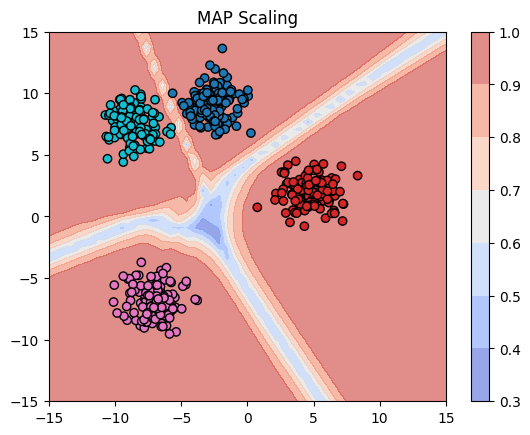

In [62]:
plot_decision_boundary_many_classes(X_train, y_train, model_manyclasses, method='MAP', title='MAP Scaling')

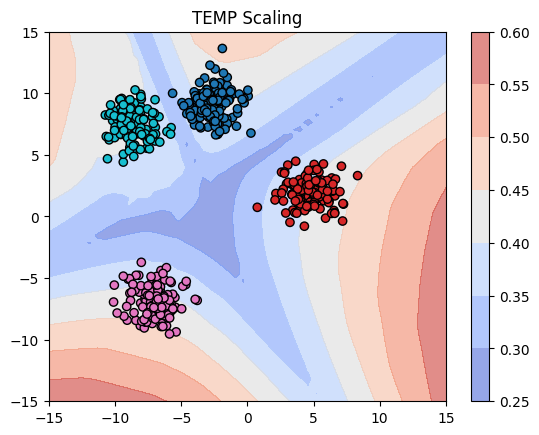

In [66]:
plot_decision_boundary_many_classes(X_train, y_train, model_manyclasses, method='TEMP', T=10, title='TEMP Scaling')

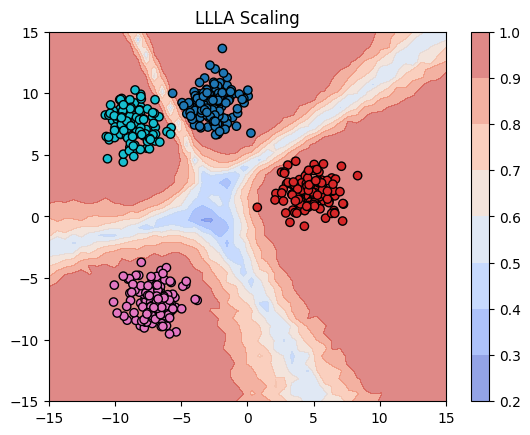

In [47]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='LLLA', var0=0.1, diag=True, title='LLLA Scaling', mc_it=100, exact=True, tau=None)

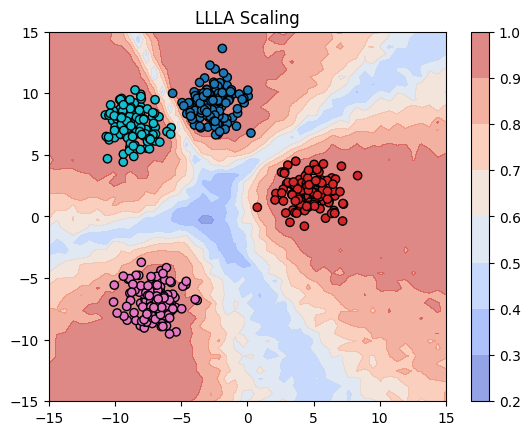

In [48]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='LLLA', var0=1, diag=False, title='LLLA Scaling', mc_it=100, exact=True, tau=1e-2)

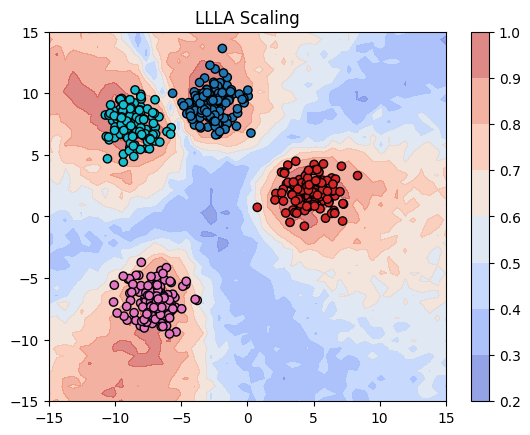

In [49]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='LLLA', var0=10, diag=False, title='LLLA Scaling', mc_it=100, exact=True, tau=None)

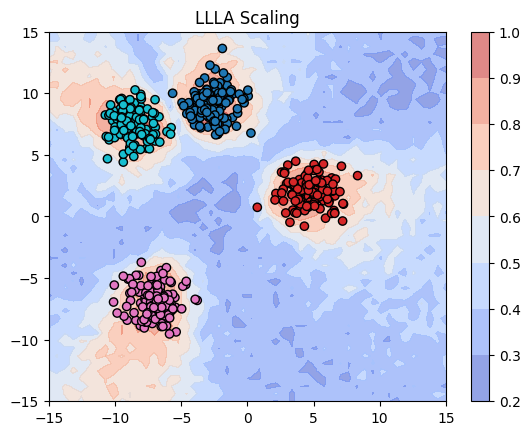

In [50]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='LLLA', var0=100, diag=False, title='LLLA Scaling', mc_it=100, exact=True, tau=None)

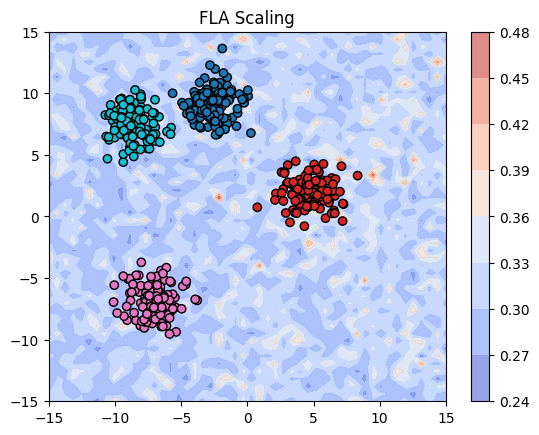

In [67]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=10, diag=True, title='FLA Scaling', mc_it=100, exact=True, tau=None)

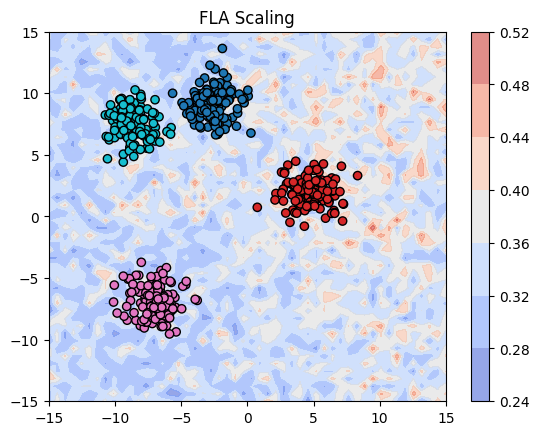

In [68]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=1, diag=True, title='FLA Scaling', mc_it=100, exact=True, tau=None)

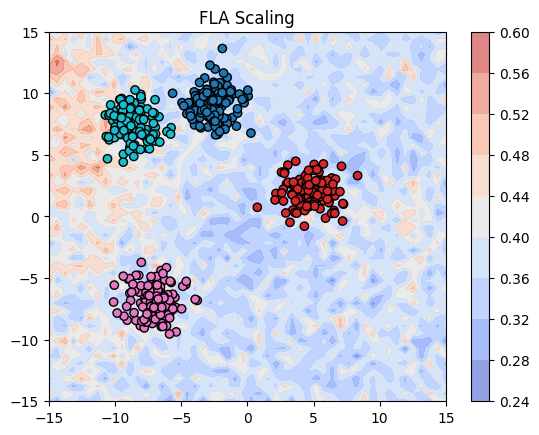

In [73]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=0.5, diag=False, title='FLA Scaling', mc_it=100, exact=True, tau=None)

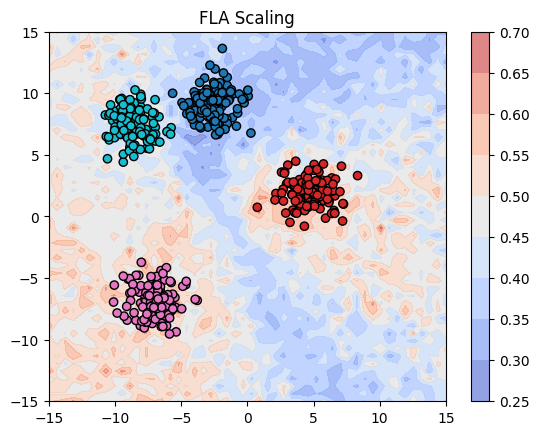

In [74]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=0.2, diag=False, title='FLA Scaling', mc_it=100, exact=True, tau=None)

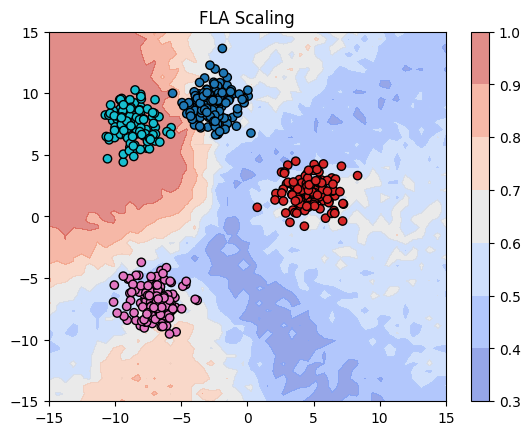

In [76]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=0.01, diag=False, title='FLA Scaling', mc_it=100, exact=True, tau=None)

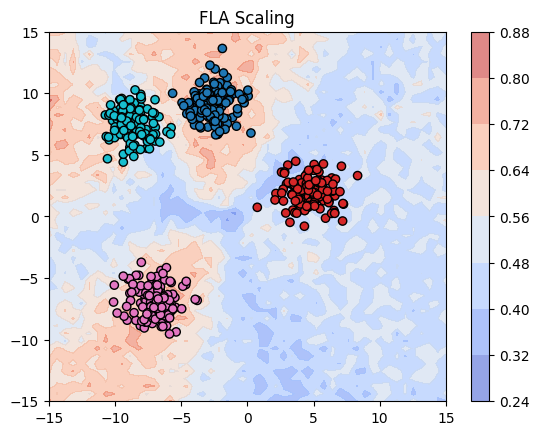

In [71]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=0.1, diag=False, title='FLA Scaling', mc_it=100, exact=True, tau=None)

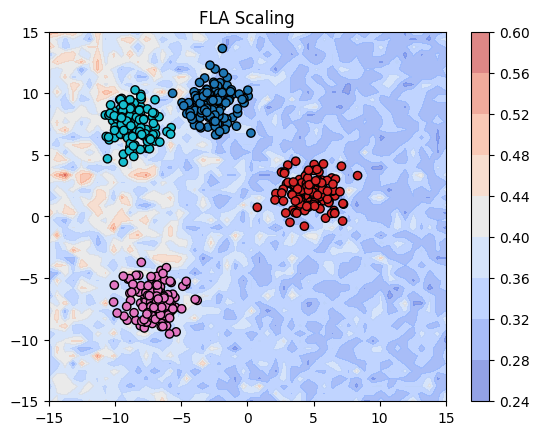

In [72]:
plot_decision_boundary_many_classes(X_train, y_train, copy.deepcopy(model_manyclasses), method='FLA', var0=1, diag=False, title='FLA Scaling', mc_it=100, exact=True, tau=None)

In [88]:
model = copy.deepcopy(model_manyclasses)
criterion = nn.CrossEntropyLoss(reduction='sum')
mean_preds = []
for delta in [1, 2, 5, 10, 50, 100, 1000]:
    preds = mc_confidence(model, criterion, X_train, y_train, delta*X_val, n_classes=4, mc_it=10, method='LLLA', var0=100, diag=True, exact=True, tau=None)
    mean_preds.append(preds.max(1).values.mean())

In [89]:
mean_preds

[tensor(0.6253),
 tensor(0.5924),
 tensor(0.5422),
 tensor(0.5020),
 tensor(0.4884),
 tensor(0.5009),
 tensor(0.4980)]

In [92]:
model = copy.deepcopy(model_manyclasses)
criterion = nn.CrossEntropyLoss(reduction='sum')
mean_preds = []
for delta in [1, 2, 5, 10, 50, 100, 1000, 10000, 100000]:
    preds = mc_confidence(model, criterion, X_train, y_train, delta*X_val, n_classes=4, mc_it=100, method='LLLA', var0=100, diag=True, exact=True, tau=None)
    mean_preds.append(preds.max(1).values.mean())

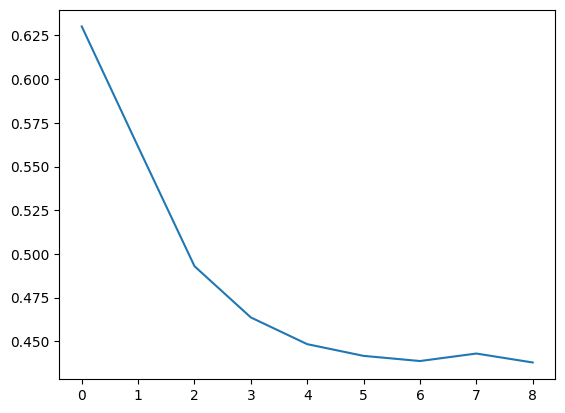

In [95]:
plt.plot(mean_preds)

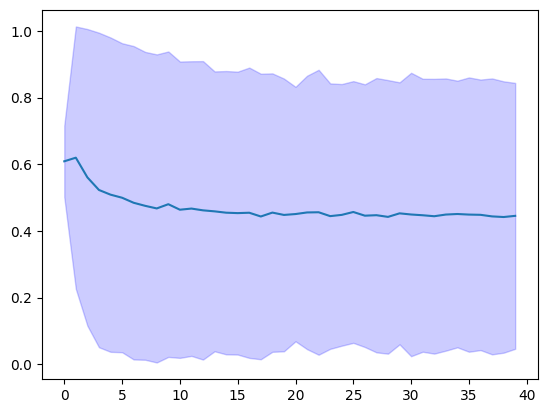

In [103]:
model = copy.deepcopy(model_manyclasses)
criterion = nn.CrossEntropyLoss(reduction='sum')
mean_preds = []
std_preds = []
for delta in range(40):
    preds = mc_confidence(model, criterion, X_train, y_train, delta*X_val, n_classes=4, mc_it=100, method='LLLA', var0=100, diag=True, exact=True, tau=None)
    max_preds = preds.max(1).values
    mean_preds.append(max_preds.mean().item())
    std_preds.append(max_preds.std().item())  # Écart-type
mean_preds = np.array(mean_preds)
std_preds = np.array(std_preds)
plt.plot(mean_preds)
plt.fill_between(range(40), mean_preds - 3 * std_preds, mean_preds + 3 * std_preds, color='blue', alpha=0.2, label="±3 std")

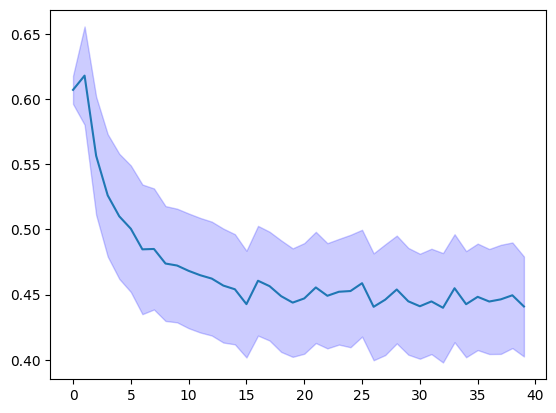

In [102]:
mean_preds = np.array(mean_preds)
std_preds = np.array(std_preds)
plt.plot(mean_preds)
plt.fill_between(range(40), mean_preds - 0.3 * std_preds, mean_preds +  0.3  * std_preds, color='blue', alpha=0.2, label="±3 std")

In [180]:
list(model_manyclasses.parameters())[-1].shape

torch.Size([4, 20])

In [178]:
list(model_manyclasses.parameters())[-1].view(20, 4)

tensor([[-0.1052, -0.3450, -0.0335, -0.4164],
        [ 0.1229, -0.4455, -0.0193, -0.0671],
        [ 0.4211,  0.0588, -0.4146,  0.3399],
        [ 0.4648, -0.3165,  0.7869, -0.1040],
        [-0.3142,  0.4758,  0.2252, -0.0222],
        [ 0.5740, -0.2330,  0.2091, -0.1939],
        [ 0.5314, -0.1312, -0.0110,  0.4800],
        [-0.1262, -0.2138, -0.3304, -0.3974],
        [-0.1847, -0.0297, -0.2231,  0.6245],
        [ 0.5446, -0.3099, -0.2526, -0.2169],
        [-0.1821, -0.1339,  0.0309,  0.6470],
        [-0.2207, -0.0540,  0.5769, -0.1994],
        [ 0.3169, -0.0390,  0.3747, -0.2578],
        [-0.1978, -0.3131, -0.3561, -0.1987],
        [-0.0581, -0.2823, -0.3974,  0.7588],
        [-0.0473,  0.4067, -0.3607, -0.3712],
        [ 0.0125,  0.6855,  0.0929, -0.2696],
        [-0.1728,  0.5025, -0.3488,  0.1009],
        [-0.0120,  0.8078, -0.3363, -0.1500],
        [-0.2740, -0.3478,  0.1721, -0.1883]], grad_fn=<ViewBackward0>)

In [191]:
W_list[0].shape

torch.Size([4, 20])

In [245]:
y_pred = model_manyclasses(X_train)
W_list = [list(model_manyclasses.parameters())[-1]]
likelihood = nn.CrossEntropyLoss(reduction='sum')(y_pred, y_train)
reg = 0
var0 = 10
for W in W_list: 
    reg += 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()
loss = likelihood + reg

hessian = compute_hessian(loss, W_list, exact=True, tau=None)
# if diag:
#     hessian = hessian.diag() * torch.eye(hessian.shape[0])
    
sigma = torch.inverse(hessian)
sigma.shape

torch.Size([80, 80])

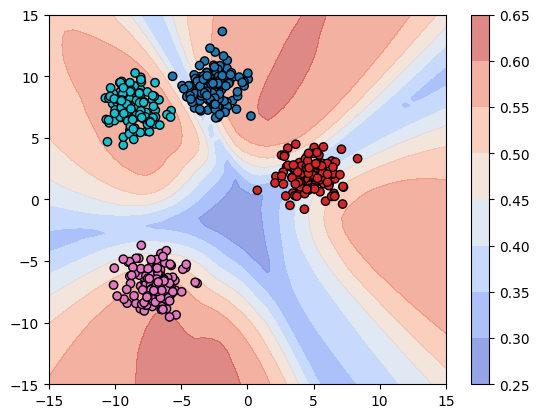

In [267]:
size = 50
test_range = (-15, 15)
xx, yy = torch.meshgrid(torch.linspace(*test_range, size, dtype=torch.float32),
                    torch.linspace(*test_range, size, dtype=torch.float32),
                    indexing='ij')
grid = torch.stack([xx.ravel(), yy.ravel()], dim=1)  # Shape (10000, 2)

W_list = [list(model_manyclasses.parameters())[-1]]

phi = model_manyclasses.feature_extr(grid)
out_4 = torch.zeros(grid.shape[0], 4)
for out_dim in range(4):
    w_map = W_list[0].view(4, -1)[out_dim]
    numerator = phi @ w_map
    denominator = torch.sqrt(1 + (torch.pi / 8) * torch.diag(phi @ sigma.view(4, 20, 4, 20)[out_dim, :, out_dim, :] @ phi.T))
    #denominator = torch.sqrt(1 + (torch.pi / 8) * torch.diag(phi @ sigma.view(20, 4, 20, 4)[out_dim, :, out_dim, :] @ phi.T))
    out_4[:, out_dim] = numerator/denominator
confidences = torch.softmax(out_4, dim=1).max(1).values.detach()

plt.contourf(xx, yy, confidences.view(50, 50), alpha=0.6, cmap='coolwarm')
plt.colorbar()



# Points des données
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', edgecolors='k')

plt.show()

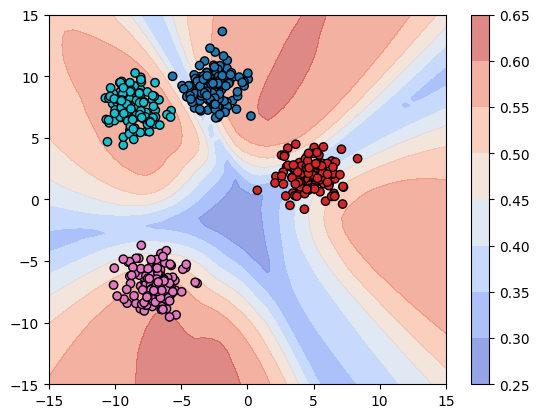

In [246]:
size = 50
test_range = (-15, 15)
xx, yy = torch.meshgrid(torch.linspace(*test_range, size, dtype=torch.float32),
                    torch.linspace(*test_range, size, dtype=torch.float32),
                    indexing='ij')
grid = torch.stack([xx.ravel(), yy.ravel()], dim=1)  # Shape (10000, 2)

W_list = [list(model_manyclasses.parameters())[-1]]

f_mu = model_manyclasses(grid)
out_4 = torch.zeros(grid.shape[0], 4)
for out_dim in range(4):
    d = []
    for i in range(grid.shape[0]):
        d_ = autograd.grad(f_mu[i][out_dim], W_list, retain_graph=True)
        d_flat = torch.cat([d_layer.view(-1) for d_layer in d_])
        d.append(d_flat)
    f_mu_ = f_mu[:, out_dim].view(-1)
    d = torch.stack(d)
    denominator = torch.sqrt(1 + (torch.pi / 8) * torch.diag(d @ sigma @ d.T))
    out_4[:, out_dim] = f_mu_/denominator
confidences = torch.softmax(out_4, dim=1).max(1).values.detach()

plt.contourf(xx, yy, confidences.view(50, 50), alpha=0.6, cmap='coolwarm')
plt.colorbar()



# Points des données
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', edgecolors='k')

plt.show()

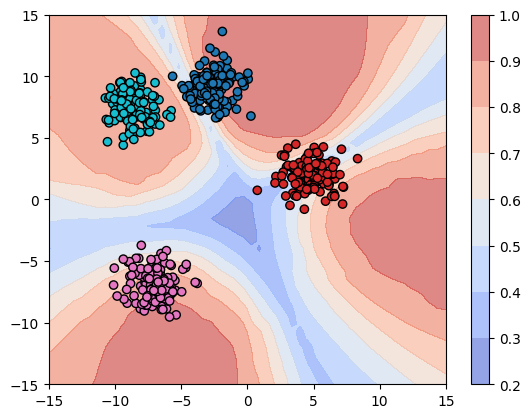

In [271]:
y_pred = model_manyclasses(X_train)
W_list = list(model_manyclasses.parameters())
likelihood = nn.CrossEntropyLoss(reduction='sum')(y_pred, y_train)
reg = 0
var0 = 0.1
for W in W_list: 
    reg += 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()
loss = likelihood + reg

hessian = compute_hessian(loss, W_list, exact=True, tau=None)
# if diag:
#     hessian = hessian.diag() * torch.eye(hessian.shape[0])
    
sigma = torch.inverse(hessian)
sigma.shape

size = 50
test_range = (-15, 15)
xx, yy = torch.meshgrid(torch.linspace(*test_range, size, dtype=torch.float32),
                    torch.linspace(*test_range, size, dtype=torch.float32),
                    indexing='ij')
grid = torch.stack([xx.ravel(), yy.ravel()], dim=1)  # Shape (10000, 2)



f_mu = model_manyclasses(grid)
out_4 = torch.zeros(grid.shape[0], 4)
for out_dim in range(4):
    d = []
    for i in range(grid.shape[0]):
        d_ = autograd.grad(f_mu[i][out_dim], W_list, retain_graph=True)
        d_flat = torch.cat([d_layer.view(-1) for d_layer in d_])
        d.append(d_flat)
    f_mu_ = f_mu[:, out_dim].view(-1)
    d = torch.stack(d)
    denominator = torch.sqrt(1 + (torch.pi / 8) * torch.diag(d @ sigma @ d.T))
    out_4[:, out_dim] = f_mu_/denominator
confidences = torch.softmax(out_4, dim=1).max(1).values.detach()

plt.contourf(xx, yy, confidences.view(50, 50), alpha=0.6, cmap='coolwarm')
plt.colorbar()



# Points des données
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', edgecolors='k')

plt.show()

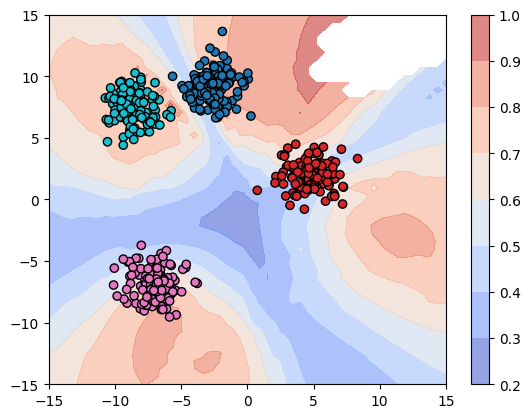

In [274]:
y_pred = model_manyclasses(X_train)
W_list = list(model_manyclasses.parameters())
likelihood = nn.CrossEntropyLoss(reduction='sum')(y_pred, y_train)
reg = 0
var0 = 1
for W in W_list: 
    reg += 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()
loss = likelihood + reg

hessian = compute_hessian(loss, W_list, exact=False, tau=1e-1)
# if diag:
#     hessian = hessian.diag() * torch.eye(hessian.shape[0])
    
sigma = torch.inverse(hessian)
sigma.shape

size = 50
test_range = (-15, 15)
xx, yy = torch.meshgrid(torch.linspace(*test_range, size, dtype=torch.float32),
                    torch.linspace(*test_range, size, dtype=torch.float32),
                    indexing='ij')
grid = torch.stack([xx.ravel(), yy.ravel()], dim=1)  # Shape (10000, 2)



f_mu = model_manyclasses(grid)
out_4 = torch.zeros(grid.shape[0], 4)
for out_dim in range(4):
    d = []
    for i in range(grid.shape[0]):
        d_ = autograd.grad(f_mu[i][out_dim], W_list, retain_graph=True)
        d_flat = torch.cat([d_layer.view(-1) for d_layer in d_])
        d.append(d_flat)
    f_mu_ = f_mu[:, out_dim].view(-1)
    d = torch.stack(d)
    denominator = torch.sqrt(1 + (torch.pi / 8) * torch.diag(d @ sigma @ d.T))
    out_4[:, out_dim] = f_mu_/denominator
confidences = torch.softmax(out_4, dim=1).max(1).values.detach()

plt.contourf(xx, yy, confidences.view(50, 50), alpha=0.6, cmap='coolwarm')
plt.colorbar()



# Points des données
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab10', edgecolors='k')

plt.show()